In [1]:
from typing import AnyStr
import os
os.chdir("..")
os.chdir("src")
from data_cleaning_pandas import DataCleaning
from nltk.stem import RSLPStemmer
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import nltk
from unidecode import unidecode
import re
nltk.download('stopwords')
os.chdir("..")

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [17]:
def word_cloud(stopwords, modelo, n_topicos, figsize=(20,20)):
    '''
    Display de word cloud.

    Parameters
    ----------
    stopwords : stopwords

    modelo : modelo usado

    n_topicos : número de tópicos

    Returns
    -------
    ax : word_clud 
    '''   
    cloud = WordCloud(stopwords=stopwords,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=7,
                    colormap='tab10',
                    prefer_horizontal=1.0)
    topics = modelo.show_topics(formatted=False)
    fig, axes = plt.subplots(1, n_topicos, figsize=figsize, sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=400)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()    
    return ax    


In [2]:
cleaning_pipeline = DataCleaning()
df = cleaning_pipeline.run()

2024-03-28 21:39:23 - INFO - Data loaded!
2024-03-28 21:39:23 - INFO - Null values cleaned!
/home/bruno/mestrado-ufrgs/mestrado-ufrgs-cmp617-tce/src/data_cleaning_pandas.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["ANO_LICITACAO"] = df_final["ANO_LICITACAO"].replace(
2024-03-28 21:39:23 - INFO - Data types asserted!
2024-03-28 21:39:23 - INFO - Full data cleaned!


In [3]:
df

,CD_ORGAO,NM_ORGAO,ANO_LICITACAO,DS_OBJETO,VL_LICITACAO,DT_HOMOLOGACAO,VL_HOMOLOGADO
0,47500,PM DE ESTÂNCIA VELHA,2017,"CONTRATAÇÃO, EXCLUSIVA PARA EMPRESAS BENEFICIÁ...",72691.16,2018-01-17,72691.16
1,75300,PM DE DERRUBADAS,2017,Aquisição de alimentos.,65808.91,2017-01-23,65808.91
2,88027,PM DE CAPÃO DO CIPÓ,2017,AQUISIÇÃO DE COMBUSTIVEIS PARA MANUTENÇÃO DA F...,1058588.00,2017-02-01,1112500.00
3,88039,PM DE PINHAL DA SERRA,2017,O objeto da presente licitação é o registro de...,1361100.00,2017-01-27,1361100.00
4,69900,PM DE PINHAL,2017,AQUISIÇÃO DE MATERIAIS DE LIMPEZA,28942.06,2017-01-25,28942.06
...,...,...,...,...,...,...,...
305595,40600,PM DE ALVORADA,2021,Registro de preço para aquisição de equipament...,3726826.37,2022-12-26,2407569.55
305596,50100,PM DE IJUÍ,2021,Credenciamento de pessoas jurídicas e/ou físic...,132015.00,NaT,132015.00
305597,55600,PM DE RIO GRANDE,2021,Exames e avaliações de Ecografias,249900.00,NaT,249900.00
305598,63400,PM DE CAPÃO DA CANOA,2021,Registro de Preços para contratação de empresa...,1736650.00,2021-09-24,664900.00


## NLP treatment

In [4]:
def remove_stop_words(words):
    stop_words = []

    with open("stop_words.txt", "r") as file:
        for row in file:
            stop_words.append(row.strip())

    return [word for word in words if word.lower() not in stop_words]

def preprocess(x: AnyStr) -> str:

    special_chars = "¨'!#$%&()*+,./:;<=>?@[\]^_`{|}~"
    new_x = x.replace('"',' ')
    for c in special_chars:
        new_x = new_x.replace(c,' ') # Removes special characters
    new_x = re.sub(r'[^\w\s]', ' ', new_x) # Removes punctuation
    new_x = re.sub("http\S+", ' ',new_x) # Removes links
    new_x = re.sub("@\w+", ' ',new_x) # Removes @
    new_x = re.sub('#\S+', ' ',new_x) # Removes hashtags
    new_x = re.sub('[0-9]+', ' ',new_x) # Removes numbers
    new_x = unidecode(new_x) # Removes accents
    new_x = re.sub("\s+", ' ',new_x) # Removes spaces

    new_x = ' '.join([word for word in new_x.split() if len(word) > 2])
    
    new_x = new_x.strip()
    return new_x

def stemmer_pt(words):
    
    stemmer = RSLPStemmer()
    return [stemmer.stem(word) for word in words]


In [5]:
df = df.assign(
    DS_OBJETO_NLP=df["DS_OBJETO"]
    .apply(lambda x: nltk.word_tokenize(x.lower(), language="portuguese")) # Tokenize
    .apply(lambda x: [preprocess(word) for word in x]) # Other preprocessing
    .apply(lambda arr: list(filter(None, arr))) # Removes items with none
    .apply(remove_stop_words) # Removes stop words
    .apply(lambda x: [word for word in x if "rs" not in word]) # Remove tokens containing "rs" (which are cities)
    .apply(stemmer_pt) # Applies stemming
)

In [9]:
from gensim.models import CoherenceModel, Phrases, phrases, ldamulticore
import gensim.corpora as corpora

In [10]:
# Construção do dicionário e do corpus
id2word = corpora.Dictionary(df["DS_OBJETO_NLP"].values.tolist())
corpus = [id2word.doc2bow(text) for text in df["DS_OBJETO_NLP"].values.tolist()]

2024-03-28 21:43:51 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2024-03-28 21:43:51 - INFO - adding document #10000 to Dictionary<6056 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizaca', 'desratizaca']...>
2024-03-28 21:43:51 - INFO - adding document #20000 to Dictionary<9082 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizaca', 'desratizaca']...>
2024-03-28 21:43:51 - INFO - adding document #30000 to Dictionary<11455 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizaca', 'desratizaca']...>
2024-03-28 21:43:51 - INFO - adding document #40000 to Dictionary<13894 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizaca', 'desratizaca']...>
2024-03-28 21:43:52 - INFO - adding document #50000 to Dictionary<15908 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizaca', 'desratizaca']...>
2024-03-28 21:43:52 - INFO - adding document #60000 to Dictionary<17764 unique tokens: ['administr', 'benefici', 'cult', 'desinsetizac

In [12]:
lda_model = ldamulticore.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=8, 
                                      random_state=42,
                                      chunksize=120,
                                      passes=8,
                                      alpha=0.01,
                                      eta=0.91,
                                      per_word_topics=True)

2024-03-28 21:44:33 - INFO - using serial LDA version on this node
2024-03-28 21:44:33 - INFO - running online LDA training, 8 topics, 8 passes over the supplied corpus of 283872 documents, updating every 1800 documents, evaluating every ~18000 documents, iterating 50x with a convergence threshold of 0.001000
2024-03-28 21:44:33 - INFO - training LDA model using 15 processes
2024-03-28 21:44:33 - INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #120/283872, outstanding queue size 1
2024-03-28 21:44:33 - INFO - PROGRESS: pass 0, dispatched chunk #1 = documents up to #240/283872, outstanding queue size 2
2024-03-28 21:44:33 - INFO - PROGRESS: pass 0, dispatched chunk #2 = documents up to #360/283872, outstanding queue size 3
2024-03-28 21:44:33 - INFO - PROGRESS: pass 0, dispatched chunk #3 = documents up to #480/283872, outstanding queue size 4
2024-03-28 21:44:33 - INFO - PROGRESS: pass 0, dispatched chunk #4 = documents up to #600/283872, outstanding queue size 5
2024-03

In [13]:

coherence_model_lda = CoherenceModel(model=lda_model, texts=df["DS_OBJETO_NLP"].values.tolist(), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

2024-03-28 21:46:40 - INFO - using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - accumulator serialized
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - accumulator serialized
2024-03-28 21:46:41 - INFO - accumulator serialized
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:46:41 - INFO - serializing accumulator to return to master...
2024-03-28 21:4

In [14]:
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.47168736315220705


## TESTAR BI GRAMS, TRI GRAMS E OUTRAS FORMAS DE STEMING/LEMATIZACAO

In [18]:
stop_words = []

with open("stop_words.txt", "r") as file:
    for row in file:
        stop_words.append(row.strip())

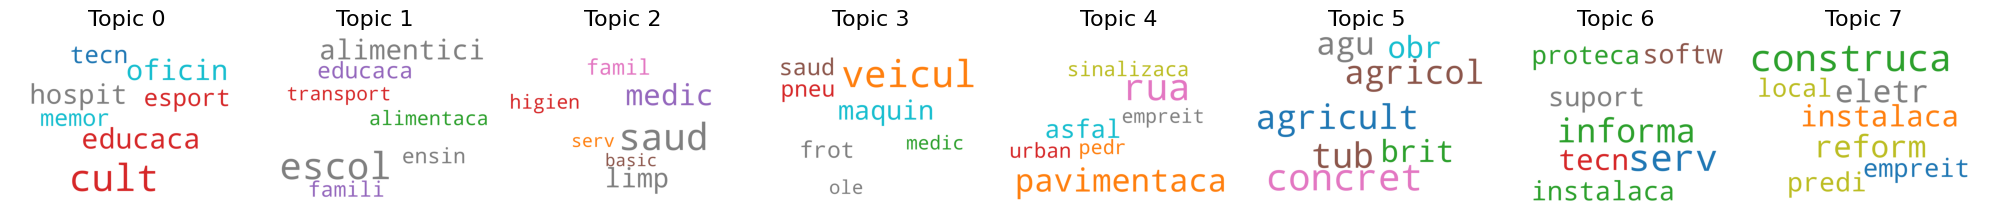

<Axes: title={'center': 'Topic 7'}>

In [19]:
word_cloud(stop_words, lda_model, 8)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
# Construção do dicionário e do corpus
id2word = corpora.Dictionary(data_words_trigrams)
corpus = [id2word.doc2bow(text) for text in data_words_trigrams]

In [15]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_tfidf)

In [17]:
num_clusters = 10 # Número de clusters desejado
kmeans = KMeans(n_clusters=num_clusters)

# Ajustar o modelo
kmeans.fit(X)

# Obter rótulos dos clusters
labels = kmeans.labels_

In [ ]:
# df = df.with_columns(pl.Series(name="CLUSTER", values=labels)) 

In [ ]:
df.collect()

CD_ORGAO,NM_ORGAO,ANO_LICITACAO,DS_OBJETO,VL_LICITACAO,DT_HOMOLOGACAO,VL_HOMOLOGADO,DS_OBJETO_NLP,CLUSTER
i64,str,i64,str,f64,date,f64,list[str],i32
72300,"""PM DE TRÊS PAL…",2017,"""Contratação de…",87000.0,2017-02-10,87000.0,"[""program"", ""computaca"", … ""execu""]",9
57100,"""PM DE SANTANA …",2017,"""REGISTRO DE PR…",8.3874e6,2017-03-08,8.3874e6,"[""eletr""]",5
71500,"""PM DE SÃO VEND…",2017,"""aquisição de c…",451107.0,2017-01-23,451107.0,"[""combusti""]",5
86800,"""PM DE BOA VIST…",2017,"""Contratação de…",613559.84,2017-02-13,613559.84,"[""empr"", ""transport"", ""escol""]",4
61200,"""PM DE TAQUARA""",2017,"""REGISTRO DE PR…",387070.0,2017-02-03,387070.0,"[""frald"", ""infantil"", … ""cib""]",8
…,…,…,…,…,…,…,…,…
88419,"""SJCDH - SECRET…",2021,"""Contração de t…",1733.0,2021-11-16,1733.0,"[""contraca"", ""trabalh"", … ""sichd""]",5
88419,"""SJCDH - SECRET…",2021,"""Aquisição de D…",1775.0,2021-08-05,1775.0,"[""dispens"", ""alcool"", … ""rol""]",5
73600,"""PM DE ARAMBARÉ…",2021,"""Concessão admi…",300.0,2021-12-24,2000.0,"[""concessa"", ""administr"", … ""total""]",5


In [ ]:
X.shape

(158425, 28901)

In [18]:
slice = 50000 
test_X = X[:slice]
test_labels = labels[:slice]

## Avaliação dos clusters

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, labels)  # X é a matriz de features e labels são os rótulos

In [19]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(test_X.toarray(), test_labels)  # X é a matriz de features e labels são os rótulos

: 

In [ ]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X.toarray(), labels)  # X é a matriz de features e labels são os rótulos


MemoryError: Unable to allocate 79.1 GiB for an array with shape (283111, 37501) and data type float64

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X é a matriz de features


In [ ]:
import umap
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)  # X é a matriz de features


In [ ]:
!pip install umap-learn

In [ ]:
import matplotlib.pyplot as plt

# Para PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [ ]:
# Para UMAP
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
plt.title('UMAP Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar()
plt.show()
